<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='imgs/UFF.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Machine Learning: Linear Classification

### [Luis Martí](http://lmarti.com)
#### [Instituto de Computação](http://www.ic.uff)
#### [Universidade Federal Fluminense](http://www.uff.br)
#### [`http://lmarti.com/2016-1-ml`](http://lmarti.com/2016-1-ml)

### About the notebook/slides

* The slides are _programmed_ as a [Jupyter](http://jupyter.org)/[IPython](https://ipython.org/) notebook.
* **Feel free to try them and experiment on your own by launching the notebooks.**

* You can run the notebook online: [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/lmarti/machine-learning)

If you are using [nbviewer](http://nbviewer.jupyter.org) you can change to slides mode by clicking on the icon:

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
      <div class='well well-sm'>
              <img src='imgs/view-as-slides.png'/>
      </div>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random, math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Fixed seed to make the results repeatable
random.seed(0)
# Pretty matrix outputs
np.set_printoptions(precision=3, threshold=1000, edgeitems=5, linewidth=80, suppress=True)

# Classification$\renewcommand{\vec}[1]{\boldsymbol{#1}}$

* Given an input vector $\vec{x}$ determine $p\left(C_k\right|\left.\vec{x}\right)$ where $k\in \{1\ldots K\}$ and $C_k$ is a 
discrete class label.

* In this class we will discuss **linear models** for classification.
* Note that the algorithms described here can also be applied to transformed input, $\phi(\vec{x})$, to determine $p\left(C_k\right|\left.\phi(\vec{x})\right)$, where $\phi$ may be a nonlinear tranformation of the input space.

Our **first model assumption** is that our target output can be modeled as

$$y(\phi(\vec{x})) = f(\vec{w}^\intercal\phi(\vec{x}))$$

where $y$ will be a vector of probabilities with $K$ elements. 

* Elements of $y$ are $y_k = p\left(C_k\right|\left.\phi(\vec{x})\right)$ i.e. the probability that the correct class label is $C_k$ given the input vector $\vec{x}$. 
* Often we will have simply that $\vec{w}^\intercal\phi(\vec{x}) = \vec{w}^\intercal\vec{x}+w_0$ in which case we will simply omit $\phi$ from the notation.
* The function $f$ is known as the **activation function** and its inverse is known as the **link function**. 
* Note that $f$ will often be nonlinear.

It should be noted that nearly all of the material presented fails to be a fully Bayesian treatment of the classification problem. Primarily this is because a Bayesian approach to the classification problem is mathematically intractable. However, Bayes' Theorem will appear often in the discussion, which can lead to confusion. Where appropriate, I will try to clarify the difference.

The target variable, $y$, does **not provide a decision** for a class assignment for a given input $\vec{x}$. 

* In real world cases where it is necessary to make a decision as to which class $\vec{x}$ should be assigned;
* one must apply an additional modeling step based on [*decision theory*](https://en.wikipedia.org/wiki/Decision_theory).

There are a variety of decision models, all of which leverage the class posterior probability models, $p\left(C_k\right|\left.\vec{x}\right)$, such as

* Minimizing the misclassification rate - this effectively corresponds to chosing the class with the highest probability for a given $\vec{x}$.
* Minimizing the expected loss - minimizes the expected value of a given loss function, $\ell(\cdot)$, under the class posterior probability distribution.
* Reject option.

## Linear models

The models discusses today are called *linear* because, 
* when the decision criteria is that of minimizing the misclassification rate, 
* they divide the input space into $K$ regions, 
* where the boundaries between regions are linear functions of the input vector $\vec{x}$. 
* The decision boundaries will correspond to where $\vec{w}^\intercal\vec{x}=\text{constant}$, and thus represent a linear function of $\vec{x}$. 
* In the case of transformed input, $\phi(\vec{x})$, the decision boundaries will correspond to where 
$\vec{w}^\intercal\phi(\vec{x})=\text{constant}$, and thus represent a linear function of $\phi(\vec{x})$. 

<div class="container-fluid">
  <div class="row">
      <div class="col-md-3"><span/></div>
      <div class="col-md-6">
          <div class='well'>
              <img class='img-thumbnail' src='https://upload.wikimedia.org/wikipedia/commons/2/20/Svm_separating_hyperplanes.png'/>
          </div>
      </div>
      <div class="col-md-3" align='center'><span/></div>
  </div>
</div>

# Probabilistic generative models

Our first step is to form a model of the class posterior probabilities for the *inference stage*:
* This can be done by modeling the *class-conditional densities*, $p\left(\vec{x}\right|\left.C_k\right)$, and the class priors, $p(C_k)$, and then applying [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) to obtain the posterior model, or
* can be done directly, as in *probabilistic discriminative modeling*.

### Bayes' theorem flashback

Bayes' theorem describes the probability of an event, based on conditions that might be related to the event.

$$ P\left(A\right|\left.B\right) = \frac{P\left(B\right|\left.A\right) \, P(A)}{P(B)},$$
where $A$ and $B$ are events.

* $P(A)$ and $P(B)$ are the probabilities of $A$ and $B$ without regard to each other.
* $P\left(A\right|\left.B\right)$, a *conditional probability*, is the probability of observing event $A$ given that $B$ is true.
$P\left(B\right|\left.A\right)$ is the probability of observing event $B$ given that $A$ is true.

* We will see that our class posterior probability model will depend only on the input $\vec{x}$ 
    * (or a fixed transformation using basis functions $\phi$) 
* and the class labels, $C_k$. In this case, for $K$ classes, our activation function will take the form of the *softmax function*
$$f = p\left(C_k\right|\left.\vec{x}\right) = \frac{\exp(a_k)}{\sum_j \exp(a_j)},$$
where $$a_j = \ln\left(p\left(\vec{x}\right|\left.C_k\right)p(C_k)\right).$$

In the **case of $K=2$**, the activation function will reduce to the *logistic sigmoid* function
$$f = p(C_1|\vec{x}) = \frac{1}{1+\exp(-a)} = \sigma(a)$$
where $$a = \ln \frac {p(\vec{x}|C_1)p(C_1)} {p(\vec{x}|C_2)p(C_2)}.$$

* Note this is not the only possible form for the class posterior models. For example, one might also add a noise term to account for misclassification. 
* This particular form for the activation function is a consequence of the model we choose for $p(\vec{x}|C_k)$ in sections below. 
* Showing the outcome may be a bit of "putting the cart before the horse" but it will simplify the notation as we proceed.
* Although we have applied Bayes' Theorem, this is **not** a Bayesian model. 
    * Nowhere have we modeled the parameter posterior probability $p(\vec{w}|\vec{t})$. 
* Indeed, we will see shortly that we will use a *maximum likelihood* approach to determine $\vec{w}$.

These models are **known as generative models** because they can be used to generate synthetic input
data by applying [inverse transform sampling](http://en.wikipedia.org/wiki/Inverse_transform_sampling) to the marginal distribution for $\vec{x}$ defined by

$$p(\vec{x}) = \sum_k p(\vec{x}|C_k)p(C_k)$$

### Model assumptions

To move forward, it is necessary to start making **model assumptions**. 
Here we will *assume* that:
* we have continuous inputs, i.e. $x\in \mathbb{R}^n$ (see Bishop p.202 and Ng Lecture 5 pdf for discrete input using Naive Bayes & Laplace), and
* that the *class-conditional densities*, $p(\vec{x}|C_k)$ are modeled by a Gaussian distribution. 

### Transformation under the Gaussian assumption

Under the Gaussian assumption, the class-conditional density  for class $C_k$ is

$$p(\vec{x}|C_k) = \frac{1}{\left(2 \pi \right)^{n/2}} \frac{1}{\left|\vec{\Sigma}\right|^{1/2}} \exp \left( -\frac{1}{2} \left(\vec{x} - \vec{\mu}_k\right)^\intercal \vec{\Sigma}^{-1} \left(\vec{x} - \vec{\mu}_k\right) \right)$$

* where $n$ is the dimension of the input vector $\vec{x}$, 
* $\vec{\Sigma}$ is the *covariance matrix*, 
* $\vec{\mu}$ is the mean vector and 
* where we have *assumed* that all classes share the same covariance matrix.

In the case of **two classes**, this result is substituted into the logistic sigmoid function and reduces to

$$p(C_1|\vec{x}) = \sigma \left( \vec{w}^\intercal \vec{x} + w_0 \right)$$

were we have defined $\vec{w} = \mathbf{\Sigma}^{-1} \left( \mathbf{\mu}_1 - \mathbf{\mu}_2 \right)$

$$w_0 = -\frac{1}{2} \vec{\mu}_1^\intercal \vec{\Sigma}^{-1} \vec{\mu}_1 + \frac{1}{2} \vec{\mu}_2^\intercal \vec{\Sigma}^{-1} \vec{\mu}_2 + \ln \frac{p(C_1)} {p(C_2)}$$

### What about the $p(C_k)$?

* The class prior probabilities, $p(C_k)$, effectively act as a bias term. 
* Note that we have yet to specify a model for these distributions. 

If we are to use the result above, we will need to make **another model assumption**. 
* We will *assume* that the *class priors* are modeled by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with $p(C_1)=\gamma$ and $p(C_2)=1-\gamma$. 

These results can be extended to the case of $K>2$ classes for which we obtain

$$a_k(\vec{x}) = \left[\vec{\Sigma}^{-1} \vec{\mu}_k \right]^\intercal \vec{x} - \frac{1}{2} \vec{\mu}_k^\intercal \vec{\Sigma}^{-1} \vec{\mu}_k + \ln p(C_k)$$

which is used in the first activation function provided at the begining of this section. 

### What about the posterior class densities

We have not formulated a complete model for the posterior class densities, in that we have not yet solved for the model parameters, $\vec{\mu}$ and $\vec{\Sigma}$. 

We do that now using a **maximum likelihood** approach.

## Maximum Likelihood Solution

Considering the case of two classes, $C_1$ and $C_2$, with 
* Bernoulli prior distributions, $p(C_1)=\gamma$ and $p(C_2)=1-\gamma$, and
* Gaussian *class-conditional density* distributions $p(\vec{x}|C_k)$, 
* assume we have a training data set, $\vec{X}$, with $m$ elements of the form $\left\{\vec{x}_i, t_i\right\}$ where $t_i=0$ indicates that $\vec{x_i}$ is in class $C_1$ and $t_i=1$ indicates that $\mathbf{x_n}$ is in class $C_2$.

The likelihood function is then given by
$$p\left(\vec{t}, \vec{X} \mid \gamma, \vec{\mu}_1, \mu_2, \vec{\Sigma}\right) = \prod_{i=1}^m \left[\gamma \mathcal{N} \left(\vec{x}_i \mid \mu_1, \vec{\Sigma}\right)\right]^{t_i} \left[\left(1-\gamma\right) ND\left(\vec{x}_i \mid \mu_2, \vec{\Sigma}\right)\right]^{1-t_i}$$ 

Taking the derivate of this expression with respect to the various model parameters, $\gamma$, $\mu_1$, $\mu_2$, and $\vec{\Sigma}$, and setting it equal to zero, we obtain the following estimates
$$\gamma = \frac{N_1}{N_1+N_2}$$
where $N_1$ is the number of training inputs in class $C_1$ and $N_2$ is the number in class $C_2$.

#### similarly...

$$\mu_1 = \frac{1}{N_1} \sum_{i=1}^m t_i \vec{x_i},$$
$$\mu_2 = \frac{1}{N_2} \sum_{i=1}^m (1-t_i) \vec{x_i}, \text{ and}$$

$$\vec{\Sigma} = \frac{1}{m}\left[ \sum_{i\in C_1} (\mathbf{x_i}-\mu_1)(\mathbf{x_i}-\mu_1)^T + \sum_{i\in C_2} (\mathbf{x_i}-\mu_2)(\mathbf{x_i}-\mu_2)^T \right].$$

## Example

* We will choose some *truth* values for our parameters and use our generative model to generate synthetic data. 
* We can then use that data as input to the maxium likelihood solution to see the estimates of the truth parameters. 
* Let's use 1-D input for simplicity. 
* We will be using a basic form of inverse transform sampling. Specifically, we wish for our training input data,  $\vec{x}$, to be dervied from a distribution modeled by the marginal distribution $p(\vec{x})$.

* To obtain this, we first formulate the cumulative distribution function, 
$CDF(\vec{X}) = \int_{-\infty}^{\vec{X}} p(\vec{x})d\vec{x}$. Note that the range of the CDF is $[0,1]$. 

* To obtain appropriately distributed $\vec{x}$ values, we choose some value from a uniform distribution on $[0,1]$, say $y$, and find the value $\vec{X}$ such that $CDF(\vec{X})=y$. 
* This value of $\vec{X}$ is our input $\vec{x}$.
* This approach requires us to find the inverse of the CDF, which we will do numerically.
* Once we have obtained a value for $\vec{x}$ we need to assign it to a particular class. 

We will *assume* that the correct class is that for which the posterior probability $p(C_k|\vec{x})$ is greatest, **unless** the difference between the two posterior probabilities is less than some minimum value in which case we will chose randomly - this will add some "noise" to our input training data.

Select truth data values, these will NOT be known to the training algorithm, they are only used in generating the sample data.

In [2]:
tu1 =-2.0
tu2 = 2.0
tSigma = 2.0
tGamma = 0.5

In [3]:
import scipy.integrate as sci_intgr
import scipy.optimize as sci_opt

Defining probabilities

In [4]:
#the class conditional probability p(x|Ck)
def p_xCk(x, mu, sigma):
    denom = math.sqrt(2.0 * math.pi * sigma)
    arg = -0.5 * (x - mu) * (x - mu) / sigma
    return math.exp(arg) / denom

In [5]:
#the marginal probability p(x)
def p_x(x, mu1, mu2, sigma, gamma):
    return gamma * p_xCk(x, mu1, sigma) + (1.0 - gamma) * p_xCk(x, mu2, sigma)

In [6]:
#posterior class probability vector (p(C_1|x), p(C_2|x))
def p_Ckx(x, mu1, mu2, sigma, gamma):
    a = math.log(p_xCk(x, mu1, sigma)*gamma/(p_xCk(x,mu2,sigma)*(1-gamma)))
    pc1 = 1.0/(1.0 + math.exp(-a))
    return (pc1, 1.0 - pc1)

In [7]:
#the cumulative distribution function P(x<X)
def cdf(x, mu1, mu2, sigma, gamma):
    return sci_intgr.quad(func=p_x, a=-np.inf, b=x, args=(mu1, mu2, sigma, gamma))

In [8]:
#inverse of the CDF
def inv_cdf(y, mu1, mu2, sigma, gamma):
    def f(x):
        return cdf(x,mu1,mu2,sigma,gamma)[0] - y
    return sci_opt.newton(f, 0)

In [9]:
domain = range(0,100,1)
domain = [(-5.0 + x/10.0) for x in domain]

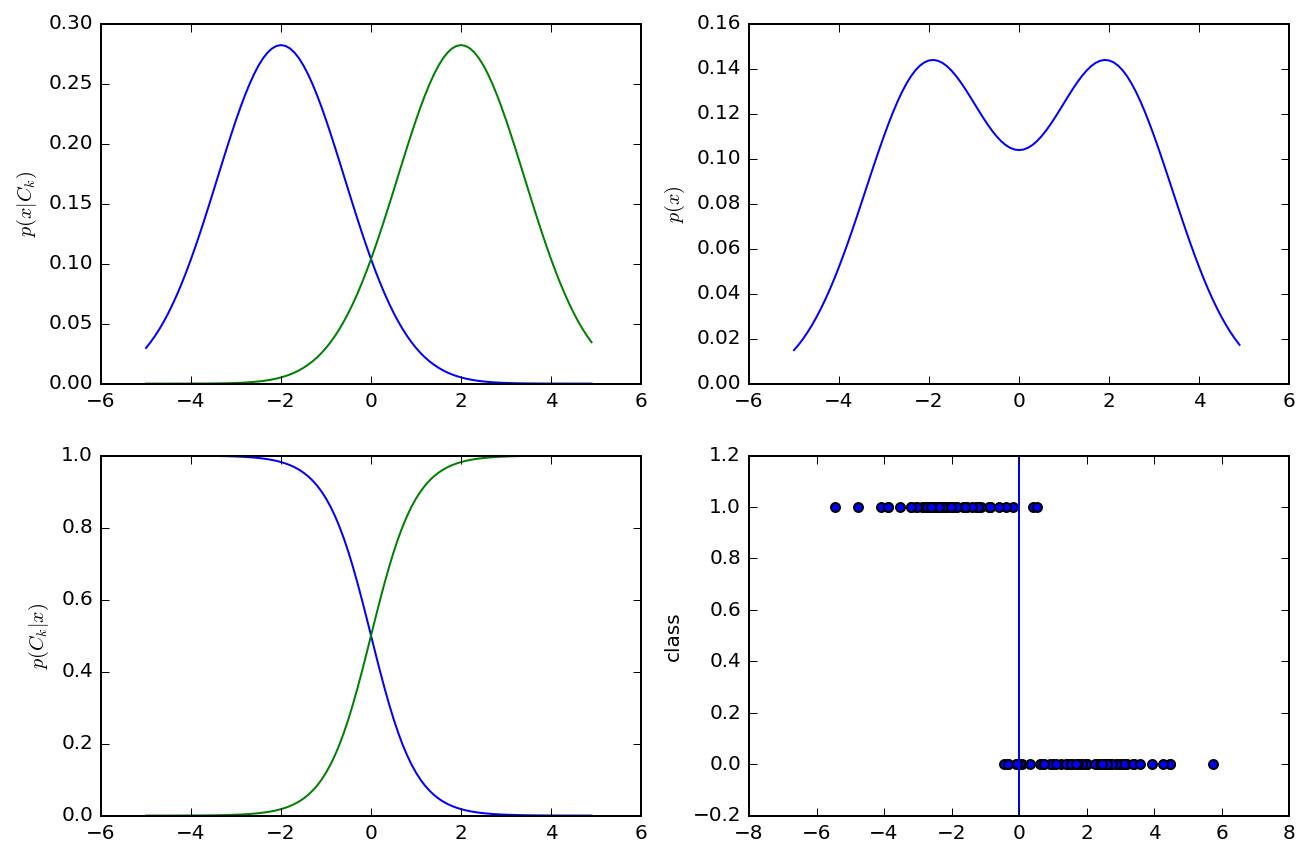

In [10]:
f, axarr = plt.subplots(2,2)
f.subplots_adjust(right=1.5)
f.subplots_adjust(top=1.5)

#plot p(x|Ck)
pxC1 = [p_xCk(x,tu1,tSigma) for x in domain]
pxC2 = [p_xCk(x,tu2,tSigma) for x in domain]
ax1 = axarr[0,0]
ax1.plot(domain, pxC1)
ax1.plot(domain, pxC2)
ax1.set_ylabel('$p(x|C_k)$')

#plot the marginal distribution p(x)
px = [p_x(x, tu1, tu2, tSigma, tGamma) for x in domain]
ax2 = axarr[0,1]
ax2.plot(domain,px)
ax2.set_ylabel('$p(x)$')

#plot the posterior distributions p(C_1|x) & p(C_2|x)
pc1x = []
pc2x = []
for x in domain:
    pck = p_Ckx(x, tu1, tu2, tSigma, tGamma)
    pc1x.append(pck[0])
    pc2x.append(pck[1])
ax3 = axarr[1,0]
ax3.plot(domain, pc1x)
ax3.plot(domain, pc2x)
ax3.set_ylabel('$p(C_k|x)$')

seed = 123456789
np.random.seed(seed)
num_samples = 100
x = np.zeros(num_samples)
t = np.zeros(num_samples)
pcx = np.zeros(num_samples)
n1 = 0
nae = 0
assignment_epsilon = 0.5
#assign x to 1 for C1 and 0 for C2
for i in range(num_samples):
    rv = np.random.uniform()
    x[i] = inv_cdf(rv, tu1, tu2, tSigma, tGamma)
    pcx1 = p_Ckx(x[i], tu1, tu2, tSigma, tGamma)
    pcx2 = pcx1[1]
    pcx1 = pcx1[0]
    #we don't want a perfect dividing line for our domain, otherwise why would we need a learning algorithim?
    if math.fabs(pcx2-pcx1) <= assignment_epsilon:
        nae = nae + 1
        if np.random.uniform() <= 0.5:
            t[i] = 1
            n1 = n1 + 1
        else:
            t[i] = 0
    elif pcx1 > pcx2:
        t[i] = 1
        n1 = n1 + 1
    else: t[i]=0

#plot the simulated data
ax4 = axarr[1,1]
ax4.scatter(x, t)
ax4.axvline(0)
ax4.set_ylabel('class')
plt.show()

## Estimating the parameters

In [11]:
n2 = num_samples - n1
eGamma = n1 / float(num_samples)

In [12]:
from functools import reduce 

In [13]:
eu1 = reduce(lambda accum, Z: accum + Z[0]*Z[1], zip(x,t), 0) / float(n1)
eu2 = reduce(lambda accum, Z: accum + Z[0]*(1-Z[1]), zip(x,t), 0) / float(n2)

In [14]:
def Sn(Z, ck, mu=(eu1,eu2)):
    idx = 1-int(ck)
    return (Z[0]-mu[idx])*(Z[0]-mu[idx])

In [15]:
eSigma = reduce(lambda accum, Z: accum + Sn(Z, Z[1]),  zip(x,t), 0) / float(num_samples)

In [16]:
print('The number of inputs in C1 is {0}'.format(n1))
print('The number of inputs that were assigned based on the assignment factor is {0}'.format(nae))
print('The true model parameters are gamma={0}, u1={1}, u2={2}, Sigma={3}'.format(tGamma, tu1, tu2, tSigma))
print('The estimated model parameters are gamma={0}, u1={1}, u2={2}, Sigma={3}'.format(eGamma, eu1, eu2, eSigma))

The number of inputs in C1 is 49
The number of inputs that were assigned based on the assignment factor is 12
The true model parameters are gamma=0.5, u1=-2.0, u2=2.0, Sigma=2.0
The estimated model parameters are gamma=0.49, u1=-2.1627582966950736, u2=2.028003758731953, Sigma=1.6660489752832408


<h1>Probabilistic Discriminative Models</h1>
Probablistic discriminative models assume the same generalized linear model <br/>

$y(\phi(\mathbf{x})) = f(\mathbf{w}^T\phi(\mathbf{x}))$

as the probabilistic generative models. However, rather than formulate models for the *class-conditional* densities, $p(\phi(\mathbf{x})|C_k)$, and the *class priors*, $p(C_k)$, the discriminative approach
explicitly models the *class posterior* probabilities, $p(C_k|\phi(\mathbf{x}))$ with model parameters $\mathbf{w}$. As in the probabilistic generative approach, maximum likelihood is used to estimate the model 
parameters given some training data set, $\mathbf{t}$. The **difference** is the form of the likelihood function. In the probabilistic generative case, the likelihood function is a function of the joint probability,
$p(\phi(\mathbf{x}),C_k)=p(\phi(\mathbf{x})|C_k)p(C_k)$. In the probabilistic discriminative approach, the likelihood function is a function of the conditional class posteriors, $p(C_k|\phi(\mathbf{x}))$ only. 

**NOTE** The section on probablistic generative models focused on models that used the input, $\mathbf{x}$, directly. However, as noted previously, those models, and the results, hold equally well for input that undergoes 
a **fixed** transformation using a set of basis functions, $\phi$. In this section, we will focus on the inclusion of an input transformation via the basis functions.

<h2>Logistic Regression</h2>
We first consider Logistic Regression, which is one specific example of discriminative modeling, for the case of two classes. It assumes a model for the class posterior probabilities, $p(C_k|\phi(\mathbf{x}))$, in the form of the logistic 
sigmoid<br/><br/>
$p(C_1|\phi) = f(a) = \sigma(\mathbf{w}^T\phi)$<br/><br/>
with $p(C_2|\phi) = 1 - p(C_1|\phi)$. We now apply maximum likelihood to obtain the model parameters. Assume that our training set, $\mathbf{t}$, is of the form $\\{\phi_n,t_n\\}$ where $\phi_n=\phi(\mathbf{x}_n)$, $t_n \in \{0,1\}$,
and $n=1\ldots N$. The likelihood function of the training data is then<br/><br/>
$p(\mathbf{t}|\mathbf{w}) = \prod_{n=1}^N \sigma(\mathbf{w}^T \phi(\mathbf{x}_n))^{t_n} (1 - \sigma(\mathbf{w}^T \phi(\mathbf{x}_n)))^{1-t_n}$ <br/><br/>
Defining the error function, $E(\mathbf{w})$, as the negative of the log-likelihood function, and taking the gradient with respect to $\mathbf{w}$, we obtain<br/><br/>
$\bigtriangledown E(\mathbf{w}) = \sum_{n=1}^N \left[\sigma(\mathbf{w}^T \phi(\mathbf{x}_n)) - t_n\right] \phi(\mathbf{x}_n)$<br/><br/>

Superficially, this error function looks the same as that obtained for **linear** regression under the assumption of a Gaussian noise model which had a closed form solution. However, the nonlinearity of the *sigmoid* function, $\sigma(\mathbf{w}^T \phi(\mathbf{x}_n))$ prevents a closed form solution in the **logistic** regression problem. We therefore must apply an iterative method to obtain a numerical solution for the parameters, $\mathbf{w}$. Here we will
consider the *Newton-Raphson* method for which minimizing the error function takes the form<br/><br/>
$\mathbf{w}^{\tau+1} = \mathbf{w}^{\tau} - \mathbf{H}^{-1}\bigtriangledown E(\mathbf{w})$<br/><br/>

where $\mathbf{H}$ is the *Hessian* matrix composed of the second derivatives of the error function<br/><br/>
$\mathbf{H} = \bigtriangledown \bigtriangledown E(\mathbf{w}) = \Phi^T \mathbf{R} \Phi$<br/><br/>

where $\Phi$ is the $N \times M$ design matrix whos $n^{th}$ row is given by $\phi(\mathbf{x_n})^T$ and $\mathbf{R}$ is an $N \times N$ diagonal matrix with elements $R_{n,n} = \sigma(\mathbf{w}^T \phi(\mathbf{x}_n)) \left[1-\sigma(\mathbf{w}^T \phi(\mathbf{x}_n))\right]$. This can be reduced to a form equivalent to that of localy weighted linear *regression* as follows<br/><br/>
$\mathbf{w}^{\tau+1} = \left( \Phi^T \mathbf{R} \Phi \right)^{-1} \Phi^T \mathbf{R} \mathbf{z}$ <br/><br/>
where $\mathbf{z}$ is an $N$ dimensional vector defined by<br/><br/>
$\mathbf{z} = \Phi \mathbf{w}^{\tau} - \mathbf{R}^{-1}(\mathbf{y} - \mathbf{t})$

<h1>Readings</h1>
<ul>
    <li>Bishop: 4.2.0-4.2.4, 4.3.0-4.3.4, 4.4, 4,5</li>
    <li>Ng: Lecture 2 pdf</li>
    <li>Ng: Lecture 5 pdf</li>
</ul>

<h2>Example 2</h2>
Let's consider an example with two classes and 2D input, $\mathbf{x_n} = (x_n^{(1)},x_n^{(2)})$. As an experiment, you can try increasing the number of training points, $N$. Eventually, the training
points will overlap so that it will not be possible to completely seperate them with the transformation provided.

The total number of iterations was 13
The total error was 0.003482221426895694
The final change in error was 0.005771801683976271
The final parameters were [ -17.844  -14.062  163.065]


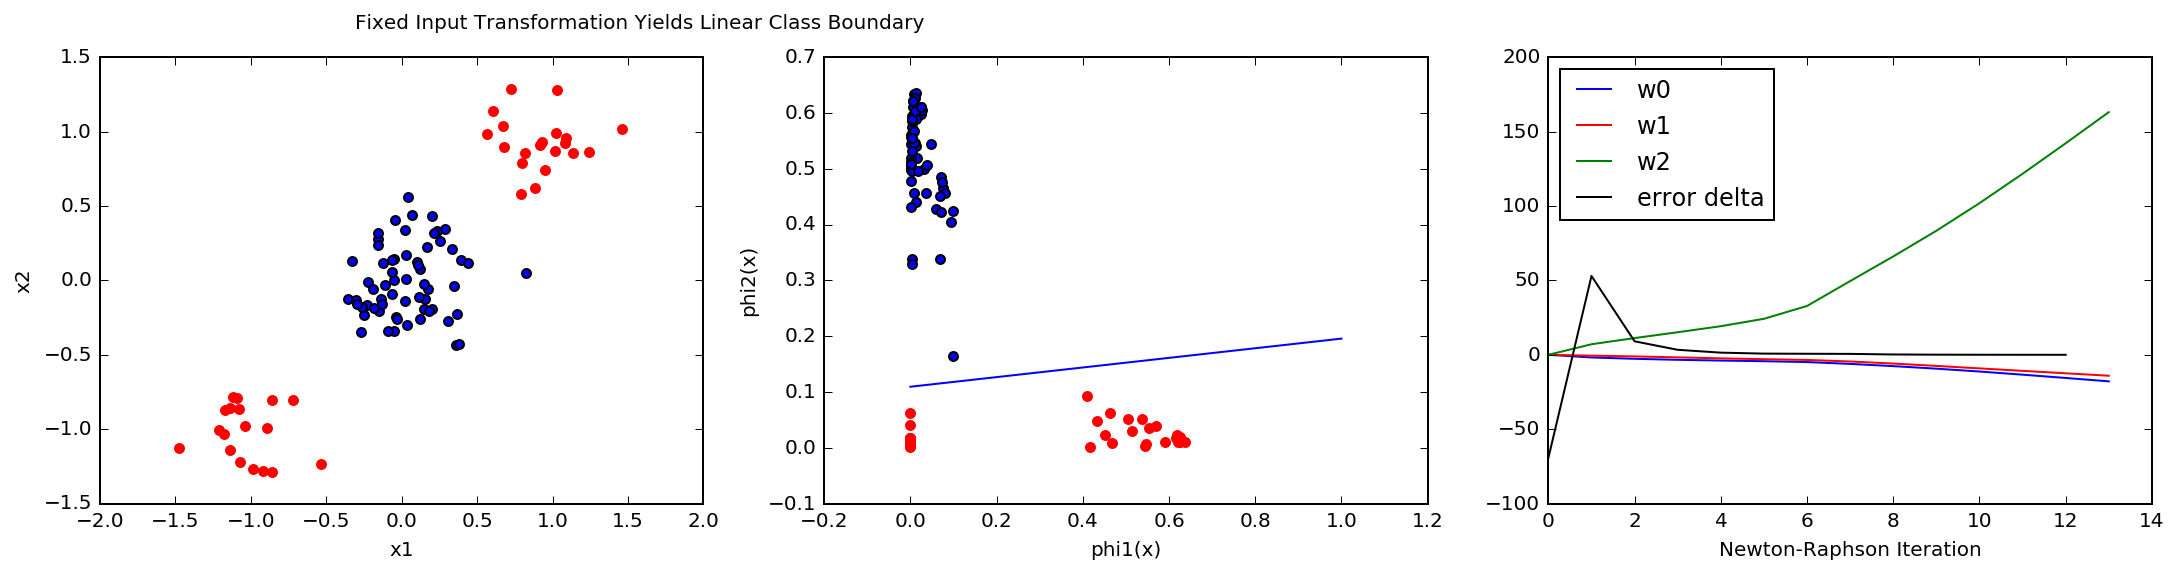

In [18]:
import numpy as np
from matplotlib import pyplot as plt

seed = 123456789
np.random.seed(seed)
N = 100 #number of data points, SEE WHAT HAPPENS AS YOU INCREASE THIS TO SAY 200
D = 2   #dimension of input vector
t = np.zeros(N) #training set classifications
X = np.zeros((N,D)) #training data in input space
sigma = .25
mu0 = 0.0
mu1 = 1.0

#func for generating 2D class scatter plot
def createScatter(X, t, ax):
    C1x = []  
    C1y = []
    C2x = []
    C2y = []
    for i in range(len(t)):
        if t[i] > 0: 
            C1x.append(X[i,0])
            C1y.append(X[i,1])
        else: 
            C2x.append(X[i,0])
            C2y.append(X[i,1])
    ax.scatter(C1x,C1y)
    ax.scatter(C2x,C2y, color='r')
    
#Generate test data. (NOTE THIS IS NOT BASED ON A GENERATIVE APPROACH. I AM PICKING SOMETHING THAT I KNOW (OK, THINK) WILL WORK. IN PRACTICE THIS DATA WOULD BE OBTAINED VIA OBSERVATION)
#Pick a value from a uniform distribution [0,1). If it is less than 0.5, assign class 1 and pick x1,x2 from a ND(mu0,sigma) otherwise assign class 2 and pick x1,x2 from ND(mu1,sigma)
for i in range(N):
    #choose class to sample for
    fac = 1
    if np.random.rand() <= 0.5:
        thismu = mu0
        t[i] = 1
    else: 
        thismu = mu1
        t[i] = 0
        if np.random.rand() < 0.5: fac = -1
        
    X[i,0] = fac * np.random.normal(thismu, sigma)
    X[i,1] = fac * np.random.normal(thismu, sigma)
    

f, axarr = plt.subplots(1,3)
f.subplots_adjust(right=2.5)
f.text(0.75,0.975,'Fixed Input Transformation Yields Linear Class Boundary',horizontalalignment='center',verticalalignment='top')

ax1 = axarr[0]
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
createScatter(X,t,ax1)

#The training data does not have a linear boundary in the original input space. So lets apply a tranformation, phi to try to make it linearly seperable
#NOTE: This transformation is not the only one that works. For example try switching the values of MU1 and MU2. The result will be a different mapping
#that is still linearly seperable
def phi(x,mu,sigma):
    detSigma = np.linalg.det(sigma)
    fac = math.pow(2*math.pi, len(mu)/2.0) * math.sqrt(detSigma)
    arg = -0.5 * np.dot((x-mu).T, np.dot(np.linalg.inv(sigma), x-mu) )
    return math.exp(arg) / fac
    
phiX = np.zeros((N,D))
MU1 = np.ones(D)*mu0
MU2 = np.ones(D)*mu1
SIGMA = np.diag(np.ones(D))*sigma
for i in range(N):
    phiX[i,0] = phi(x=X[i,:], mu=MU2, sigma=SIGMA)
    phiX[i,1] = phi(x=X[i,:], mu=MU1, sigma=SIGMA)
    
ax2 = axarr[1]
ax2.set_xlabel('phi1(x)')
ax2.set_ylabel('phi2(x)')
createScatter(phiX, t, ax2)

#Now lets apply machine learning to determine the boundary. We will assume M = 3, i.e. that there are 3 free parameters that is w = [w0, w1, w2]^T and phi_n = [1, phiX[0], phiX[1]]
M = 3
Phi = np.ones((N,M))
Phi[:,1] = phiX[:,0]
Phi[:,2] = phiX[:,1]
w = np.zeros(M)
R = np.zeros((N,N))
y = np.zeros(N)

def sigmoid(a):
    return 1.0 / (1.0 + math.exp(-a))

def totalErr(y,t):
    e = 0.0
    for i in range(len(y)):
        if t[i] > 0:
            e += math.log(y[i])
        else:
            e += math.log(1.0 - y[i])
    return -e

#start Newton-Raphson. As a stopping criteria we will use a tolerance on the change in the error function and a max number of iterations
max_its = 100
tol = 1e-2
w0 = [w[0]] 
w1 = [w[1]]
w2 = [w[2]]
err = []
error_delta = 1 + tol
current_error = 0
idx = 0
while math.fabs(error_delta)>tol and idx < max_its:
    #update y & R
    for i in range(N): 
        zipped = zip(w, Phi[i,:])
        y[i] = sigmoid(reduce(lambda accum, Z: accum + Z[0]*Z[1], zipped, 0))
        R[i,i] = y[i] - y[i]*y[i]
    #update w
    z = np.dot(Phi,w) - np.dot(np.linalg.pinv(R),y-t)
    temp = np.linalg.pinv(np.dot(np.dot(Phi.T,R),Phi))
    temp2 = np.dot(np.dot(temp, Phi.T),R)
    w = np.dot(temp2, z)
    w0.append(w[0])
    w1.append(w[1])
    w2.append(w[2])
    idx += 1
    temp = totalErr(y,t)
    error_delta = current_error - temp
    current_error = temp
    err.append(error_delta)
print('The total number of iterations was {0}'.format(idx))
print('The total error was {0}'.format(current_error))
print('The final change in error was {0}'.format(error_delta))
print('The final parameters were {0}'.format(w))  
    
#our decision boundary is now formed by the line where sigma(a) = 0.5, i.e. where a = 0, which for this example is where phi2 = -(w1/w2)phi1, i.e. where w * phi = .5
bdryx = (0,1)
bdryy = (-(w[0]+w[1]*bdryx[0])/w[2], -(w[0]+w[1]*bdryx[1])/w[2])
ax2.plot(bdryx, bdryy)

ax3 = axarr[2]
ax3.plot(w0, color = 'blue')
ax3.plot(w1, color = 'red')
ax3.plot(w2, color = 'green')
ax3.plot(err, color = 'black')
ax3.legend(("w0","w1","w2", "error delta"), loc='upper left')
ax3.set_xlabel('Newton-Raphson Iteration')

<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>

In [19]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.2.0
OS Darwin 15.4.0 x86_64 i386 64bit
scipy 0.17.0
numpy 1.10.4
matplotlib 1.5.1
Wed May 04 10:41:25 2016 BRT

In [20]:
# this code is here only for cosmetic reasons
from IPython.core.display import HTML
def css_styling():
    return HTML(open('custom/custom.include', 'r').read())
css_styling()